In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "codellama/CodeLlama-34b-Instruct-hf",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-14 13:47:25 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 07-14 13:47:25 [__init__.py:239] Automatically detected platform cuda.


2025-07-14 13:47:27,475	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.5.3: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 7/7 [03:28<00:00, 29.73s/it]


codellama/CodeLlama-34b-Instruct-hf does not have a padding token! Will use pad_token = <unk>.


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'smart_contract_train.csv',
    'val': 'smart_contract_val.csv',
    'test': 'smart_contract_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

import random

random.seed(42)

SYSTEM_PROMPT = [
    """You are the smartest AI solidity smart contract security auditor in the world that **only** answer/respond in term of "Vulnerable Code" or "Safe Code" """
]

PROMPTS = [
    """You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks. Only answer the label **WITHOUT EXPLANATION**.
    
    This is the function we need to audit:
    ```solidity
    {code}
    ```
    
Answer: """
]

def make_conversational_vote(examples, prompt):
    code = examples['code']
    selected_system_prompt = random.choice(SYSTEM_PROMPT)
    vulnerable = "Vulnerable Code" if examples['vulnerable'] == 1 else "Safe Code"
    conversation = [
        {"role": "system", "content": selected_system_prompt},
        {"role": "user", "content": prompt.format(code=code)}
    ]
    return {"conversations": conversation, "label": vulnerable, "vuln_code": code}

# Generate 5 datasets using different prompts
datasets = []
for i, prompt in enumerate(PROMPTS):
    new_dataset = dataset.map(lambda ex: make_conversational_vote(ex, prompt))
    new_dataset = new_dataset.remove_columns(["project_id", "code", "code_analysis", "vulnerable"])
    datasets.append(new_dataset)
    
test_dataset = datasets[0]['test']

Map: 100%|██████████| 278/278 [00:00<00:00, 6490.85 examples/s]


In [ ]:
import re
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm  # Import tqdm for progress bar
import pandas as pd

def extract_llm_res(raw_llm):
    # Regex pattern to extract the assistant's response after the "Vulnerability Explanation" section
    pattern = r'\[/INST](.*?)</s>'

    match = re.search(pattern, raw_llm, re.DOTALL)

    if match:
        assistant_response = match.group(1).strip()
        return assistant_response
    else:
        if "Vulnerable Code" in raw_llm:
            return "Vulnerable Code"
        else :
            return "Safe Code"
        print(f"No response found. Response: {raw_llm}")

# Set up the tokenizer and model for fast inference
tokenizer = get_chat_template(
    tokenizer,
    chat_template="llama",
)
FastLanguageModel.for_inference(model)  # Enable native 2x faster inference

# Initialize the result collection
results = []

# Iterate over the dataset with tqdm for progress bar
for idx, example in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Processing dataset"):
    messages = example['conversations']  # Get the conversation for the current entry
    
    # Tokenize input
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,  # Must add for generation
        return_tensors="pt",
    ).to("cuda")

    # Get LLM output
    outputs = model.generate(input_ids=inputs, max_new_tokens=8, use_cache=True,
                             temperature=0.1, min_p=0.1)
    raw_out = tokenizer.batch_decode(outputs)[0]
    
    # Extract LLM response
    llm_output = extract_llm_res(raw_out)
    
    # Get the ground truth for the current entry
    ground_truth = example['label']
    
    results.append({
        "vuln_code": example['vuln_code'],
        "ground_truth": ground_truth,
        "llm_output": llm_output
    })

# After the loop, you can convert the results list to a DataFrame or another suitable format if needed
verification_results_df = pd.DataFrame(results)

Processing dataset: 100%|██████████| 278/278 [06:30<00:00,  1.41s/it]


In [4]:
y_pred = [0 if "Safe Code" in x else 1 for x in verification_results_df['llm_output']]
y_true = [0 if "Safe Code" in x else 1 for x in verification_results_df['ground_truth']]

In [5]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       148
           1     0.4676    1.0000    0.6373       130

    accuracy                         0.4676       278
   macro avg     0.2338    0.5000    0.3186       278
weighted avg     0.2187    0.4676    0.2980       278



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.47      1.00      0.64       130

    accuracy                           0.47       278
   macro avg       0.23      0.50      0.32       278
weighted avg       0.22      0.47      0.30       278



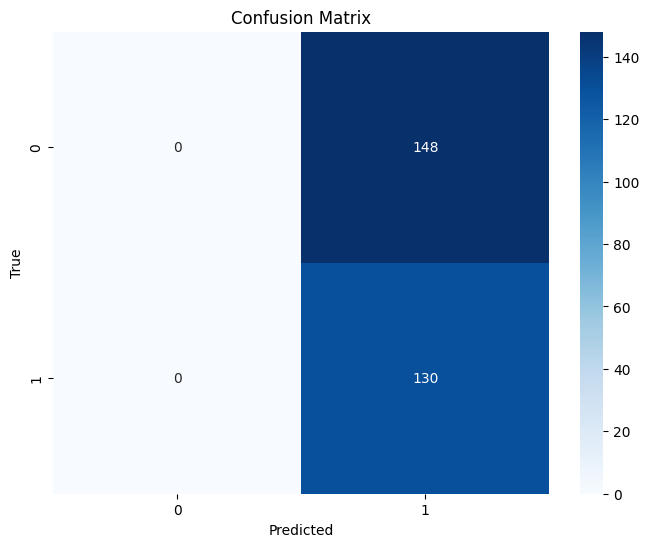

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(y_pred)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()